# CS 584 Assignment 4 -- Sequence to Sequence Models

#### Name: Pranshu Savani


## In this assignment, you are required to follow the steps below:
1. Review the lecture slides.
2. Implement a Seq2Seq model.

*** Please note that there are many online resources for Seq2Seq models, you are allowed to check them, but DO NOT DIRECTLY COPY from them. Otherwise, you will get ZERO for this assignment. ***

In [ ]:
!pip install numpy scikit-learn tqdm matplotlib
!pip install -U spacy
!python -m spacy download en_core_web_sm
!python -m spacy download es_core_news_sm
!pip install sacrebleu

# 1. Data Process
In this section, you are required to 
1. Divide the data into train, validation, and test.
2. Preprocess the text data

**Note:** The default dataset is for Spanish-English. Feel free to change other pairs of languages, you can find them [here](http://www.statmt.org/europarl/).

In [3]:
import numpy as np
from tqdm.notebook import tqdm

def load_data(filepath):
    texts = []
    with open(filepath, 'r', encoding='utf-8') as f:
        count = len(f.readlines())
        
    with open(filepath, 'r', encoding='utf-8') as f:
        for line in tqdm(f, total=count):
            texts.append(line.strip())
            
    return np.array(texts[:20000])

sources = load_data('/content/drive/MyDrive/CS-584-HW4/es-en/text.en')
targets = load_data('/content/drive/MyDrive/CS-584-HW4/es-en/text.es')

print('English sentences size:', sources.shape)
print('Spanish sentences size:', targets.shape)

  0%|          | 0/1965734 [00:00<?, ?it/s]

  0%|          | 0/1965734 [00:00<?, ?it/s]

English sentences size: (20000,)
Spanish sentences size: (20000,)


## 1.1 Divide the data into train, validation, and test

In [4]:
from sklearn.model_selection import train_test_split

source_train, source_test, target_train, target_test = train_test_split(sources, targets, test_size=0.2)
source_train, source_valid, target_train, target_valid = train_test_split(source_train, target_train, test_size=0.2)

train_texts = [(sent_source, sent_target) for sent_source, sent_target in zip(source_train, target_train)]
valid_texts = [(sent_source, sent_target) for sent_source, sent_target in zip(source_valid, target_valid)]
test_texts = [(sent_source, sent_target) for sent_source, sent_target in zip(source_test, target_test)]

print('The size of training set:', len(train_texts))
print('The size of valid set:', len(valid_texts))
print('The size of test set:', len(test_texts))

The size of training set: 12800
The size of valid set: 3200
The size of test set: 4000


## 1.2 Data preprocessing
1. Lowercase the text
2. Tokenize the text
3. Create vocabulary for the source language and target language, respectively.

In [5]:
import re
import string
import spacy
from itertools import chain
from unicodedata import normalize, category

nlp_en = spacy.load('en_core_web_sm')
nlp_es = spacy.load('es_core_news_sm')


def tokenize_en(text):
    text = re.sub(r'’', '\'', text) # some of texts contain invalid apostrophes, such as ’
    text = normalize('NFD', text).encode('ascii', 'ignore').decode('UTF-8')
    text = re.sub(r'([.!.?])', r' \1', text)
    text = re.sub(r'[^a-zA-Z-]', r' ', text)
    # tokens = text.lower().strip().split()
    doc = nlp_en(text.lower())
    return [token.text for token in doc]
    # return tokens

def tokenize_es(text):
    doc = nlp_es(text.lower())
    return [token.text for token in doc]

def preprocess(texts, type='en'):
    if type == 'en':
        return [tokenize_en(text) for text in tqdm(texts, desc='en')]
    elif type == 'es':
        return [tokenize_es(text) for text in tqdm(texts, desc='es')]

def generate_vocab(tokenized_texts):
    # Flatten the input to 1d array, Thanks for: 
    # https://stackoverflow.com/questions/29244286/how-to-flatten-a-2d-list-to-1d-without-using-numpy
    vocab = list(chain.from_iterable(tokenized_texts))
    return list(set(vocab))

source_tokens = preprocess(source_train, 'en')
target_tokens = preprocess(target_train, 'es')

source_vocab = generate_vocab(source_tokens)
source_vocab.insert(0, '<start>')
source_vocab.insert(0, '<end>')
source_vocab.insert(0, '<unk>')
source_token2idx = {token: idx for idx, token in enumerate(source_vocab)}

target_vocab = generate_vocab(target_tokens)
target_vocab.insert(0, '<start>')
target_vocab.insert(0, '<end>')
target_vocab.insert(0, '<unk>')


target_token2idx = {token: idx for idx, token in enumerate(target_vocab)}

print('English vocab size:', len(source_vocab))
print('Spanish vocab size:', len(target_vocab))

en:   0%|          | 0/12800 [00:00<?, ?it/s]

es:   0%|          | 0/12800 [00:00<?, ?it/s]

English vocab size: 11837
Spanish vocab size: 19785


In [38]:
SOS_tok = 2
EOS_tok = 1

In [7]:
train_set = [([source_token2idx[t] for t in tokenize_en(source)], [target_token2idx[t] for t in tokenize_es(target)]) for source, target in train_texts]
valid_set = [([source_token2idx[t] if t in source_token2idx else 0 for t in tokenize_en(source)], [target_token2idx[t] if t in target_token2idx else 0 for t in tokenize_es(target)]) for source, target in valid_texts]
test_set = [([source_token2idx[t] if t in source_token2idx else 0 for t in tokenize_en(source)], [target_token2idx[t] if t in target_token2idx else 0 for t in tokenize_es(target)]) for source, target in test_texts]


## 2. Seq2Seq Model (50 points)
In this section, you are required to 
1. Implement a seq2seq model which includes a CNN encoder and an RNN based decoder.  
2. For each RNN cell, try a simple RNN, LSTM, and GRU.  
3. Use the validation set to compute the BLEU score and report the best choice.

**Note:** you could use any package you are comfortable with, such as PyTorch and TensorFlow.

In [8]:
import torch
import torch.nn as nn
import torch.optim as optim
import random
import math

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

### 2.1 Encoder (25 points)

Try a simple RNN, LSTM, and GRU

In [10]:
class Encoder(nn.Module):
  def __init__(self, emb_size=256, hid_size=512, p=0.5,fl_cell = 'lstm'):
    super().__init__()
    # create embedding layer
    self.embdng = nn.Embedding(len(source_vocab), emb_size)
    # initialize dropout
    self.p = nn.Dropout(p)
    # initialize encoder neural network
    if fl_cell == 'gru':
      self.rnn = nn.GRU(emb_size, hid_size)
    elif fl_cell == 'rnn':
      self.rnn = nn.RNN(emb_size,hid_size)
    else:
      self.rnn = nn.LSTM(emb_size,hid_size)
    
  def forward(self, src):
    # get embedding for input
    emb = self.dropout(self.embdng(src))
    # pass vectorized embedding to the network
    _, hidden = self.rnn(emb) 
    # hidden = (hidden,cell) if fl_cell = 'lstm'
    # no cell state for GRU or simple RNN
    
    return hidden

### 2.2 CNN Encoder (Extra Credit)

A traditional encoder of Seq2Seq models is an RNN-based model, such as RNN, LSTM, or GRU. But CNNs can also be encoders. In this sub-section, you need to implement a CNN encoder for your Seq2Seq model.

**Hint:** We already learned how CNN can be applied to sentence classification tasks. You can simply drop the last layer of TextCNN and output the context vector. Please check this [paper](https://arxiv.org/abs/1510.03820) for details.

### 2.3 Decoder (25 points)
Try a simple RNN, LSTM, and GRU

In [11]:
class Decoder(nn.Module):
  def __init__(self, emb_size=256, hid_size=512, p=0.5, fl_cell = 'lstm'):
    super().__init__()
    # create embedding layer
    self.embdng = nn.Embedding(len(target_vocab), emb_size)
    # initialize decoder neural network
    if fl_cell == 'gru':
      self.rnn = nn.GRU(emb_size, hid_size)
    elif fl_cell == 'rnn':
      self.rnn = nn.RNN(emb_size, hid_size)
    else:
      self.rnn = nn.LSTM(emb_size, hid_size)
    # output layer of nn
    self.output_lyr = nn.Linear(hid_size , len(target_vocab))
    self.p = nn.Dropout(p)
      
  def forward(self, inp, hid):
    # get input tensors(first input is context vector)
    inp = inp.unsqueeze(0)
    # get embeddings
    emb = self.p(self.embdng(inp))
    # pass context to get new output
    out, hid = self.rnn(emb, hid)
    # get prediction from output layer
    w_p = self.output_lyr(out.squeeze(0))
    return w_p, hid

In [12]:
class seq2seq(nn.Module):
    def __init__(self, encoder, decoder, device):
        super().__init__()
        # initialize encoder and decoder
        self.encoder = encoder
        self.decoder = decoder
        self.device = device
    def forward(self, src, targ, tfr = 0.5):
        # initialize tensor to store decoded outputs
        outs = torch.zeros(targ.shape[0], targ.shape[1], len(target_vocab)).to(self.device)
        # get encoder output, final hidden state of encoder is actually the context vecotr we need
        cntxt_vec = self.encoder(src)
        # initialize decoder hidden state with context vector from encoder
        hid = cntxt_vec
        # initialize first input token
        inp = targ[0,:]
        for t in range(1, targ.shape[0]):
            #insert input token embedding and previous hidden state to recieve predictions and new hidden state
            out, hid = self.decoder(inp, hid)
            # greedy decode max probability prediction as candidate for next input
            maxp = out.argmax(1) 
            # use teacher forcing for faster convergence
            if random.random() < tfr:
              inp = targ[t]
            else:
              inp = maxp
            # store predictions to return values
            outs[t] = out
        return outs

## 3. Training your Seq2Seq (30 points)
1. Implement training process
2. Use validation set to calculate BLEU score
3. Plot your training loss and validation loss (You could use the code in assignment 1)

In [13]:
# initialize encoders and decoders for RNN, LSTM and GRU respectively
ncdr_rnn = Encoder(fl_cell='rnn')
dcdr_rnn = Decoder(fl_cell='rnn')
ncdr_lstm = Encoder(fl_cell='lstm')
dcdr_lstm = Decoder(fl_cell='lstm')
ncdr_gru = Encoder(fl_cell='gru')
dcdr_gru = Decoder(fl_cell='gru')
# create seq2seq model object for each cell type
mdl_rnn = seq2seq(ncdr_rnn, dcdr_rnn, device).to(device)
mdl_lstm = seq2seq(ncdr_lstm, dcdr_lstm, device).to(device)
mdl_gru = seq2seq(ncdr_gru, dcdr_gru, device).to(device)


In [16]:
# these functions convert our data to padded batches with same dimensions to input into the model
def pad_batches(data):
  max_src = 0
  max_trg = 0
  src = []
  trg = []
  for pair in data:
    if len(pair[0])==0 or len(pair[1])==0:
      continue
    if not (pair[0][0]==SOS_tok):
      pair[0].insert(0,SOS_tok)
      pair[1].insert(0,SOS_tok)
    if(len(pair[0])>max_src):
      max_src=len(pair[0])
    if(len(pair[1])>max_trg):
      max_trg = len(pair[1])

  for pair in data:
    if len(pair[0])==0 or len(pair[1])==0:
      continue
    while(len(pair[0])<max_src):
      pair[0].append(EOS_tok)
    src.append(pair[0])
    while(len(pair[1])<max_trg):
      pair[1].append(EOS_tok)
    trg.append(pair[1])
  return src,trg


def get_batches(dataset,batch_size=32):
  bsize = batch_size
  b_srcs = []
  b_trgs = []
  for i in range(int(len(dataset)/bsize)+1):
    start = i*bsize
    end = (i+1)*bsize
    
    if end>len(dataset) and start<=len(dataset):
      end=len(dataset)
    if start==end:
      break
    
    src,trg = pad_batches(dataset[start:end])
    b_srcs.append(src)
    b_trgs.append(trg)
  return (b_srcs,b_trgs)


In [17]:
# get padded batches for train and valid, defualt batchsize used is 32
t_set = train_set.copy()
v_set = valid_set.copy()
train_batches = get_batches(train_set)
valid_batches = get_batches(valid_set)

  0%|          | 0/1000 [00:00<?, ?it/s]

Training Loss: 9.7224
Validation Loss: 7.0103
Training Loss: 6.8973
Validation Loss: 6.8828
Training Loss: 6.8457
Validation Loss: 6.7344
Training Loss: 6.7311
Validation Loss: 6.6884
Training Loss: 6.6953
Validation Loss: 6.6749
Training Loss: 6.5745
Validation Loss: 6.6745
Training Loss: 6.6069
Validation Loss: 6.6564
Training Loss: 6.5803
Validation Loss: 6.6365
Training Loss: 6.4390
Validation Loss: 6.6279
Training Loss: 6.5464
Validation Loss: 6.6086
Training Loss: 6.5722
Validation Loss: 6.6136
Training Loss: 6.5084
Validation Loss: 6.6058
Training Loss: 6.5300
Validation Loss: 6.5826
Training Loss: 6.4996
Validation Loss: 6.5929
Training Loss: 6.4226
Validation Loss: 6.5880
Training Loss: 6.5124
Validation Loss: 6.5772
Training Loss: 6.4070
Validation Loss: 6.6056
Training Loss: 6.4138
Validation Loss: 6.6034
Training Loss: 6.4655
Validation Loss: 6.5946
Training Loss: 6.4286
Validation Loss: 6.6029
Training Loss: 6.4880
Validation Loss: 6.5778
Training Loss: 6.3550
Validation L

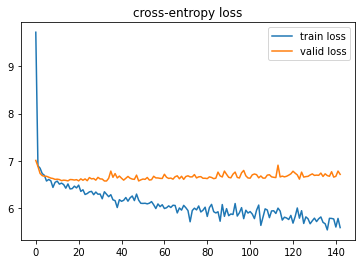

  0%|          | 0/1000 [00:00<?, ?it/s]

Training Loss: 10.4935
Validation Loss: 7.3128
Training Loss: 6.9616
Validation Loss: 6.9813
Training Loss: 6.9042
Validation Loss: 6.8362
Training Loss: 6.7117
Validation Loss: 6.7100
Training Loss: 6.6181
Validation Loss: 6.6462
Training Loss: 6.5481
Validation Loss: 6.6122
Training Loss: 6.6128
Validation Loss: 6.5856
Training Loss: 6.5874
Validation Loss: 6.5679
Training Loss: 6.5612
Validation Loss: 6.5588
Training Loss: 6.5211
Validation Loss: 6.5482
Training Loss: 6.4637
Validation Loss: 6.5400
Training Loss: 6.4695
Validation Loss: 6.5424
Training Loss: 6.4749
Validation Loss: 6.5377
Training Loss: 6.4021
Validation Loss: 6.5328
Training Loss: 6.3373
Validation Loss: 6.5255
Training Loss: 6.4691
Validation Loss: 6.5267
Training Loss: 6.4396
Validation Loss: 6.5396
Training Loss: 6.4386
Validation Loss: 6.5191
Training Loss: 6.3854
Validation Loss: 6.5140
Training Loss: 6.3874
Validation Loss: 6.5414
Training Loss: 6.3998
Validation Loss: 6.5387
Training Loss: 6.3022
Validation 

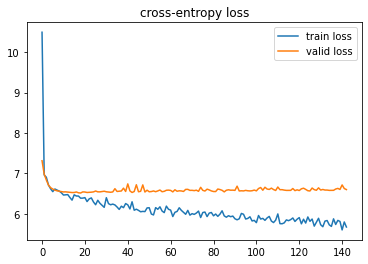

  0%|          | 0/1000 [00:00<?, ?it/s]

Training Loss: 10.9883
Validation Loss: 7.4516
Training Loss: 7.0568
Validation Loss: 7.1266
Training Loss: 7.0468
Validation Loss: 7.0963
Training Loss: 7.0587
Validation Loss: 6.9261
Training Loss: 6.7830
Validation Loss: 6.8034
Training Loss: 6.7261
Validation Loss: 6.8017
Training Loss: 6.7082
Validation Loss: 6.8083
Training Loss: 6.8105
Validation Loss: 6.7910
Training Loss: 6.7186
Validation Loss: 6.7419
Training Loss: 6.5841
Validation Loss: 6.7206
Training Loss: 6.6477
Validation Loss: 6.6950
Training Loss: 6.5997
Validation Loss: 6.6755
Training Loss: 6.5070
Validation Loss: 6.6744
Training Loss: 6.5735
Validation Loss: 6.6639
Training Loss: 6.5138
Validation Loss: 6.6602
Training Loss: 6.5777
Validation Loss: 6.6367
Training Loss: 6.5673
Validation Loss: 6.6240
Training Loss: 6.4110
Validation Loss: 6.6108
Training Loss: 6.5620
Validation Loss: 6.6300
Training Loss: 6.4033
Validation Loss: 6.6049
Training Loss: 6.4386
Validation Loss: 6.6066
Training Loss: 6.4132
Validation 

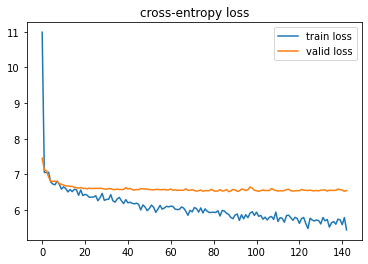

In [18]:
# training the models
import matplotlib.pyplot as plt

models=[]
models.append(mdl_rnn)
models.append(mdl_lstm)
models.append(mdl_gru)
batches = train_batches
vbatches = valid_batches
# define cross entropy loss
criterion = nn.CrossEntropyLoss(ignore_index = EOS_tok)
# loop through each model for training
for mdl_num,model in enumerate(models):
  # initialize optimizer
  optimizer = optim.Adam(model.parameters())
  num_epochs = 1000
  # best_valid_loss = float('inf')

  t_losses = []
  v_losses = []
  loss_every = 0
  for epoch in tqdm(range(num_epochs)):
    model.train()
    # get random batch from train data
    idx = random.randint(0,len(batches[0])-1)
    # convert batch into tensor for nn input
    src_t = torch.tensor(batches[0][idx],dtype=torch.long, device=device)
    trg_t = torch.tensor(batches[1][idx],dtype=torch.long, device=device)
    src = torch.transpose(src_t,0,1)
    trg = torch.transpose(trg_t,0,1)
    optimizer.zero_grad()
    # get output
    pred = model(src, trg)
    dist_size = pred.shape[-1]
    # flatten output to feed into cross entropy
    pred = pred[1:].view(-1, dist_size)
    trg = trg[1:].reshape(-1)
    loss = criterion(pred, trg)
    # update weights
    loss.backward()
    torch.nn.utils.clip_grad_norm_(model.parameters(), 1)
    optimizer.step()
    # record loss per ~200 iterations
    loss_every += loss.item()
    if ((epoch%7==0 or epoch==num_epochs-1) and not(epoch==0)):
      if epoch%7==0:
        train_loss = loss_every/7
      else:
        train_loss = loss_every/((num_epochs-1)%7)
      t_losses.append(train_loss)
      epoch_loss=0
      # calculate validation loss
      # same as train loss but not updating weights via back propogation and step
      model.eval()
      vloss_every = 0
      with torch.no_grad():
        for i in range(len(vbatches[0])):
          vsrc_t = torch.tensor(vbatches[0][i],dtype=torch.long, device=device)
          vtrg_t = torch.tensor(vbatches[1][i],dtype=torch.long, device=device)
          vsrc = torch.transpose(vsrc_t,0,1)
          vtrg = torch.transpose(vtrg_t,0,1)
          vpred = model(vsrc, vtrg, 0)
          vdist_size = vpred.shape[-1]
          vpred = vpred[1:].view(-1, vdist_size)
          vtrg = vtrg[1:].reshape(-1)
          vloss = criterion(vpred, vtrg)
          vloss_every += vloss.item()
      valid_loss = vloss_every/len(vbatches[0])
      v_losses.append(valid_loss)

      print(f'Training Loss: {train_loss:.4f}')
      print(f'Validation Loss: {valid_loss:.4f}')
  # plot valid and train losses
  plt.plot(t_losses,label='train loss')
  plt.plot(v_losses,label='valid loss')
  plt.legend()
  plt.title('cross-entropy loss')
  plt.show()

## 4. Evaluation (20 points)
1. Calculate the BLEU scores of the best seq2seq model obtained from section 2&3 on the test set.
2. Select 20 test examples, For each example, print the translation result of your model along with the ground truth

### 4.1 Calculate the BLEU score on test set. (10 points)

In [84]:
import sacrebleu
def cal_bleu_score(model, dataset, print_pred=False):
    
  model.eval()
  with torch.no_grad():
    dec_sents = []
    trg_sents = []
    src_sents = []
    for pair in dataset:
      if((len(pair[1])==0) or (len(pair[0])==0)):
        continue
      if not pair[0][-1]==EOS_tok:
        pair[0].append(EOS_tok)
        pair[0].insert(0,SOS_tok)
        pair[1].append(EOS_tok)
        pair[1].insert(0,SOS_tok)
      src = torch.tensor(pair[0], dtype=torch.long, device=device).view(-1, 1)
      trg = torch.tensor(pair[1], dtype=torch.long, device=device).view(-1, 1)
      preds = model(src, trg, 0) 
      dist_size = preds.shape[-1]
      preds = preds[1:].view(-1, dist_size)
      src = src[1:].reshape(1,-1)
      key_list = list(target_token2idx.keys())
      skey_list = list(source_token2idx.keys())
      # val_list = list(target_token2idx.values())
      decoded_words = ''
      trg_wrds = ''
      src_wrds = ''
      for i in range(len(preds)):
        pred_idx = preds[i].topk(1)
        if not (pred_idx[1].item()==EOS_tok):
          decoded_words=decoded_words+key_list[pred_idx[1].item()]+' '
        if i<len(pair[1]):
          if not(pair[1][i]==EOS_tok) and  not(pair[1][i]==SOS_tok):
            trg_wrds=trg_wrds+key_list[pair[1][i]]+' '
        if(i<len(pair[0])):
          if not(pair[1][i]==SOS_tok) and not(pair[0][i]==EOS_tok):
            src_wrds=src_wrds+skey_list[pair[0][i]]+' '
      if not (trg_wrds==''):# and not(src_wrds==''):
        dec_sents.append(decoded_words)
        trg_sents.append(trg_wrds)
        src_sents.append(src_wrds)
    if(print_pred):
      for i in range(20):
        print('English              :  ' + src_sents[i])
        print('ground-truth spanish :  ' + trg_sents[i])
        print('predicted spanish    :  ' + dec_sents[i])
        
      
  return sacrebleu.corpus_bleu(dec_sents,trg_sents).score


In [35]:
bs_val_rnn = cal_bleu_score(mdl_rnn, valid_set)
bs_val_lstm = cal_bleu_score(mdl_lstm, valid_set)
bs_val_gru = cal_bleu_score(mdl_gru, valid_set)

print('valid set BLEU scores :')
print(f' RNN  : {bs_val_rnn:4f}')
print(f' LSTM : {bs_val_lstm:4f}')
print(f' GRU  : {bs_val_gru:4f}')



 Valid set BLEU Scores :
 RNN  : 0.239300
 LSTM : 0.243800
 GRU  : 0.289900


In [64]:
# best model is GRU
bs_test = cal_bleu_score(mdl_gru, test_set)

print(f'best model BLEU for test data: {bs_test:4f}')

best model BLEU for test data: 0.394800


### 4.2 Translate 20 test exmaples. (10 points)

In [85]:
bleu_sc_test = cal_bleu_score(mdl_gru, test_set, print_pred=True)

English              :  they can be the <unk> for a while only by means of a drop in quality for their customers and employees   
ground-truth spanish :  la única manera que tienen de ser las más <unk> durante algún tiempo es a base de pérdida de calidad para los clientes y el personal . 
predicted spanish    :  la de de de de de de de de de de de de de de de de de de de de de de de de de de de 
English              :  madam president   the best tribute that my group and this house can pay to fernando buesa is to take on board his vision   as a european   of the basque country   spain and europe   
ground-truth spanish :  si me permite , señora presidenta , creo que el mejor homenaje que pueden rendir mi grupo y esta asamblea a fernando buesa es recoger lo que él decía , como europeo , sobre su visión del país vasco , de españa y de europa . 
predicted spanish    :  señor presidente , señor presidente , la comisión , la comisión de la de de la de de la de de la de de la de de la de de 